(Before reading this article, take a look at [this link](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/SVM_multiclass_time.pdf) for comparison)

This is the second post on multiclass classification using SVM. In the last article, we had used time domain features as input to SVM and seen its results. Here, we will apply SVM on wavelet packet energy features and obtain slightly higher accuracy as compared to previous case. We will again use [Case Western Reserve University Bearnig](https://csegroups.case.edu/bearingdatacenter/pages/welcome-case-western-reserve-university-bearing-data-center-website) data set for our multiclass classification problem.

## Description of data set

(We will use the same data set and the description is same as previous case. We will repeat the same thing here for the sake of completeness and to make it independent of previous one.)

A bearing has four major parts: inner race, outer race, rolling element and cage. Fault can occur in any of these components. The CWRU data set contains bearing data consisting of inner race fault, outer race fault and ball defect. A baseline (normal) bearing data with no faults is also available. Some data are collected at a sampling frequency of 12 kHz and some other are collected at 48 kHz. In this study, we will only consider data acquired at 48 kHz sampling frequency. The faults have varying fault depths (0.007 inch, 0.014 inch, 0.021 inch). There is also load variation in motor (No load, 1 hp, 2 hp, 3hp). For this study, we will consider all the data with 1 hp external load.

There are 10 classes for this external load (1 hp). The classes are:


* C1  : Ball defect (0.007 inch)
* C2  : Ball defect (0.014 inch)
* C3  : Ball defect (0.021 inch)
* C4  : Inner race fault (0.007 inch)
* C5  : Inner race fault (0.014 inch)
* C6  : Inner race fault (0.021 inch)
* C7  : Normal
* C8  : Outer race fault (0.007 inch, data collected from 6 O'clock position)
* C9  : Outer race fault (0.014 inch, 6 O'clock)
* C10 : Outer race fault (0.021 inch, 6 O'clock)

## Solution Approach

Our task is to classify these 10 types of fault given time data. There are many approaches to solve this. We will take one known as 'Shallow Approach'. In the age of deep learning these methods are shallow for several reasons. These methods require hand crafted features to be designed and fed into the learning algorithm. Another name for shallow approach is feature based approach. We will use support vector machine (SVM) to do the classification. We will apply other techniques including deep learning techniques in later posts. 

![Wavelet decomposition](wavelets_fig.png)

Wavelet analysis is a signal processing technique that gives us time-frequency representation. The inner working of wavelets is different from traditional time-frequency methods (for example, spectrograms). We will not go into the details of wavelets here (It is saved for a later post.). Wavelet packets are a way of segregating a signal into different frequency bands. A pictorial representation (above figure) will make the difference between wavelets and wavelet packets clear. (Note on notation: S-Signal, H- Low pass filter, G- High pass filter, $\downarrow 2$ - Downsampling by factor of 2, A1- Approximation coefficients corresponding to low frequency, D1- Detail coefficients corresponding to high frequency)


![Wavelet packet decomposition](wavelet_packet_fig.png)

In wavelet packet transform (above figure), after three stages of transformation we get 8 nodes. From each node coefficients we reconstruct the signal and obtain its energy. Thus we get 8 energy features and because these energies are calculated from wavelet packets, we call these wavelet packet energy features. There are many mother wavelets that can be used (for example, Haar, Sym8, Daubechies, etc.). We have used 'Sym8' as a shrinked version of it can approximate impulses well. 

Here is how we form feature matrix. First data for each fault type are collected and segmented into smaller parts. In our case, one segment for each fault type contains 2048 data points. Then 8 wavelet packet features for each segment are calculated and assembled in a feature matrix. There are 230 segments for each fault and we have taken 8 wavelet packets. (We could also have considered 16 wavelet packet thus getting 16 wavelet packet features. But we have stopped at 8 as is usually done in research.) Thus our feature matrix is of size $(2300 \times 8)$. One column containing fault type is also added to the feature matrix. Thus final feature matrix is of size $(2300 \times 9)$. 

Before applying SVM, the data are first separated into a training set and a test set. The test set contains 75 rows of fault matrix chosen for each fault type. Thus its size is $(750 \times 9)$. The rest are taken as training set. 

SVM is applied to training set data and best parameters are chosen by cross validation. The best parameters are then applied to test set data to predict final classification result. We have not printed the intermediate results. Readers can easily print those as per requirement. We will use R to implement SVM. To plot confusion matrix, we will use Python.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

### How to get data?
Readers can download the `.csv` file used in this notebook from [here](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/data/feature_wav_energy8_48k_2048_load_1.csv). Another convenient way is to [download the whole repository](https://codeload.github.com/biswajitsahoo1111/cbm_codes_open/legacy.zip/master) and run the downloaded notebooks.

In [2]:
data_wav_energy = pd.read_csv("./data/feature_wav_energy8_48k_2048_load_1.csv")

In [3]:
data_wav_energy['fault'] = pd.Categorical(data_wav_energy['fault'])

Divide the into training and test set.

In [4]:
train_data, test_data = train_test_split(data_wav_energy, test_size = 750, stratify = data_wav_energy['fault'],
                                         random_state = 123)
test_data['fault'].value_counts()

OR_021_6_1    75
OR_014_6_1    75
OR_007_6_1    75
Normal_1      75
IR_021_1      75
IR_014_1      75
IR_007_1      75
Ball_021_1    75
Ball_014_1    75
Ball_007_1    75
Name: fault, dtype: int64

Before applying SVM, it is always a better idea to scale the data.

In [5]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data.iloc[:,:-1])

In [6]:
test_data_scaled = (test_data.iloc[:,:-1].values - scaler.mean_)/np.sqrt(scaler.var_)

We will check a grid of parameters to find the best one. For each parameter combination, 10 fold cross-validation is performed.

In [7]:
parameters = {"C":[1, 10, 50, 100, 500, 1000, 5000],
             'gamma':[0.05, 0.1, 0.5, 1, 5],
             'kernel':["rbf"]}

In [8]:
tuned_svm_clf = GridSearchCV(SVC(),parameters,n_jobs = -1, cv= 10)

In [9]:
tuned_svm_clf.fit(train_data_scaled, train_data['fault'])

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 10, 50, 100, 500, 1000, 5000],
                         'gamma': [0.05, 0.1, 0.5, 1, 5], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [10]:
tuned_svm_clf.best_score_

0.9916129032258064

In [11]:
tuned_svm_clf.best_params_

{'C': 5000, 'gamma': 0.05, 'kernel': 'rbf'}

Now we will used the best model to find test accuracy.

In [12]:
best_clf = tuned_svm_clf.best_estimator_
best_clf

SVC(C=5000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [13]:
train_predictions = best_clf.predict(train_data_scaled)
test_predictions = best_clf.predict(test_data_scaled)

In [14]:
train_confu_matrix = confusion_matrix(train_data['fault'], train_predictions)
test_confu_matrix = confusion_matrix(test_data['fault'], test_predictions)

Train confusion matrix.

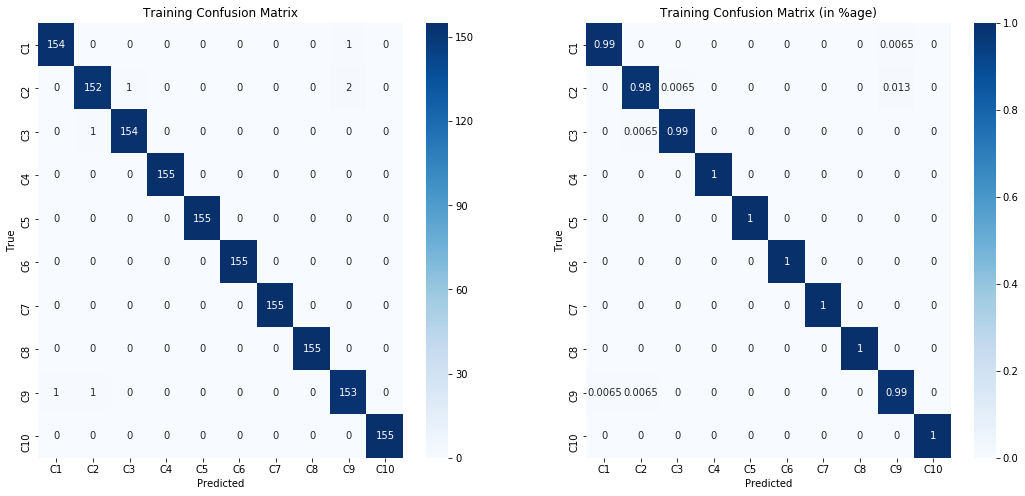

In [15]:
fault_type = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
plt.figure(1,figsize=(18,8))
plt.subplot(121)
sns.heatmap(train_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)
sns.heatmap(train_confu_matrix/155, annot= True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.title('Training Confusion Matrix (in %age)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Test confusion matrix.

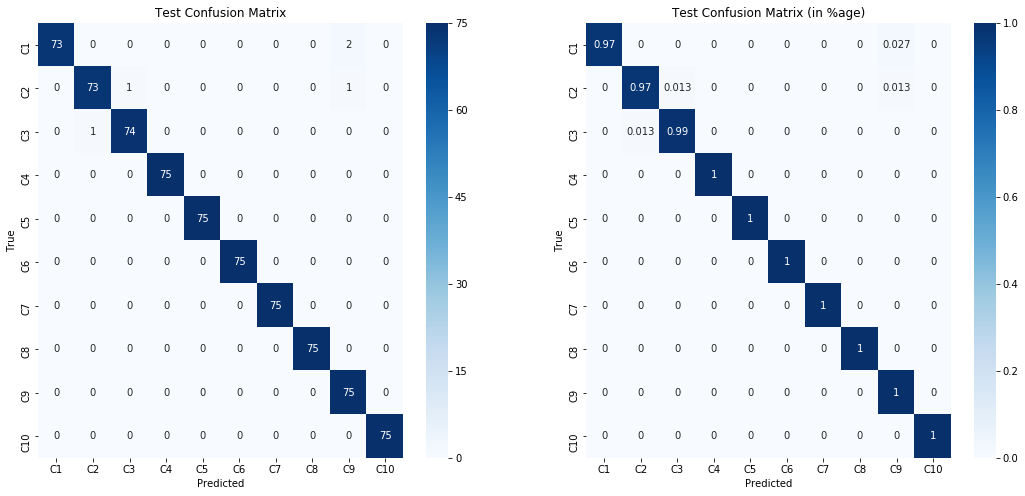

In [16]:
plt.figure(2,figsize=(18,8))
plt.subplot(121)
sns.heatmap(test_confu_matrix, annot = True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)
sns.heatmap(test_confu_matrix/75, annot = True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.title('Test Confusion Matrix (in %age)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
overall_test_accuracy = accuracy_score(test_data['fault'], test_predictions)
print("Overall test accuracy: ", overall_test_accuracy)

Overall test accuracy:  0.9933333333333333


Now the overall test accuracy is 99.3% which is a substantial improvement over the time domain methods. This method has set the benchmark in accuracy. In future we will apply other techniques to CWRU data and compare their performance with this. Check [this page](https://biswajitsahoo1111.github.io/cbm_codes_open/) for further details.

## Note: 

* More details about wavelet packet features and the ways (with codes) to compute it will appear in a future post. For the time being, readers can download and use the feature matrix already created by us. [Check this page for latest updates](https://biswajitsahoo1111.github.io/cbm_codes_open/).